In [1]:
import matplotlib.pyplot as plt

import numpy as np
import torch
torch.set_default_dtype(torch.float64)

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.sampling import draw_sobol_samples

In [2]:
bounds = torch.tensor([[-3.], [3.]])

In [8]:
def sin(x, noise=True):
    if noise:
        return torch.clip(torch.sin(x*2*torch.pi) + torch.rand(x.shape), None, 0)
    else:
        return torch.clip(torch.sin(x*2*torch.pi), None, 0)

def cos(x, noise=True):
    if noise:
        return torch.cos(x*2*torch.pi) + torch.rand(x.shape)
    else:
        return torch.cos(x*2*torch.pi)

### Create objective functions via GPs

In [10]:
x_observed = np.random.uniform(*bounds, 20).reshape(-1, 1)
x_observed = torch.tensor(x_observed)
y_observed = sin(x_observed)

x_dense = np.linspace(*bounds, 1000).reshape(-1, 1)
x_dense = torch.tensor(x_dense)

In [11]:
gp = SingleTaskGP(x_observed, y_observed)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)
with torch.no_grad():
    gp_posterior = gp.posterior(x_dense)

### Visualize function

In [12]:
num_init = 5
x_obs = draw_sobol_samples(bounds, num_init, 1).reshape((num_init, -1))
x_obs = torch.cat((x_obs, torch.tensor([[-3.0], [3.0]])))
with torch.no_grad():
    y_obs = gp(x_obs).mean

In [13]:
class SMGO:
    def __init__(self, alpha=0.001, phi=1.025):
        self.x_obs = None
        self.y_obs = None
        self.gamma = None
        self.alpha = alpha
        self.phi = phi

    @staticmethod
    def compute_lipschitz_constant(x_obs, y_obs):
        gamma = []
        for i in range(len(x_obs) -1):
            for j in range(i+1, len(x_obs)):
                gamma.append(torch.abs(y_obs[i] - y_obs[j]) / torch.norm(x_obs[i] - x_obs[j]))
        return np.amax(gamma)*1.5

    @staticmethod
    def compute_mid_points(x_obs):
        x_mid = []
        _, indices = torch.sort(x_obs, dim=0)
        for i in range(len(x_obs) - 1):
            x_mid.append(0.5 * (x_obs[indices[i]] + x_obs[indices[i+1]]))
        return torch.tensor(x_mid).reshape(-1, 1)

    def fit(self, x_obs, y_obs):
        self.gamma = self.compute_lipschitz_constant(x_obs, y_obs)
        self.x_obs = x_obs
        self.y_obs = y_obs

    def predict(self, x):
        # num_obs x num_query x input_dim
        lipschitz_func = self.gamma * torch.norm(self.x_obs[:, None, :] - x, dim=2)
        y_upper = lipschitz_func + self.y_obs.repeat(len(x), 1).T
        y_lower = - lipschitz_func + self.y_obs.repeat(len(x), 1).T
        return torch.amin(y_upper, dim=0), torch.amax(y_lower, dim=0)

    def propose(self):
        min_idx = torch.argmin(self.y_obs)
        x_obs_min = self.x_obs[min_idx]
        y_obs_min = self.y_obs[min_idx]

        def s(x, y):
            return (y - y_obs_min) / torch.norm(x - x_obs_min)

        # Exploitation mode
        x_intercept = []
        for x, y in zip(self.x_obs, self.y_obs):
            intercept = (x_obs_min + 0.5 * (1 - s(x, y) / self.gamma) * (x - x_obs_min)).item()
            if not np.isnan(intercept):
                x_intercept.append(intercept)
        x_intercept = torch.tensor(x_intercept)
        _, y_intercept = smgo.predict(x_intercept.reshape(-1, 1))
        
        intercept_min = torch.argmin(y_intercept)
        if y_intercept[intercept_min] <= y_obs_min - self.alpha * self.gamma:
            print("Exploitation")
            return x_intercept[intercept_min].reshape(-1, 1)

        # Exploration mode
        else:
            print("Exploration")
            x_mid = self.compute_mid_points(self.x_obs)
            upper, lower = self.predict(x_mid)
            uncertainty = upper - lower
            return x_mid[torch.argmax(uncertainty)].reshape(-1, 1)

In [14]:
smgo = SMGO()
smgo.fit(x_obs, y_obs)
preds_upper, preds_lower = smgo.predict(x_dense)

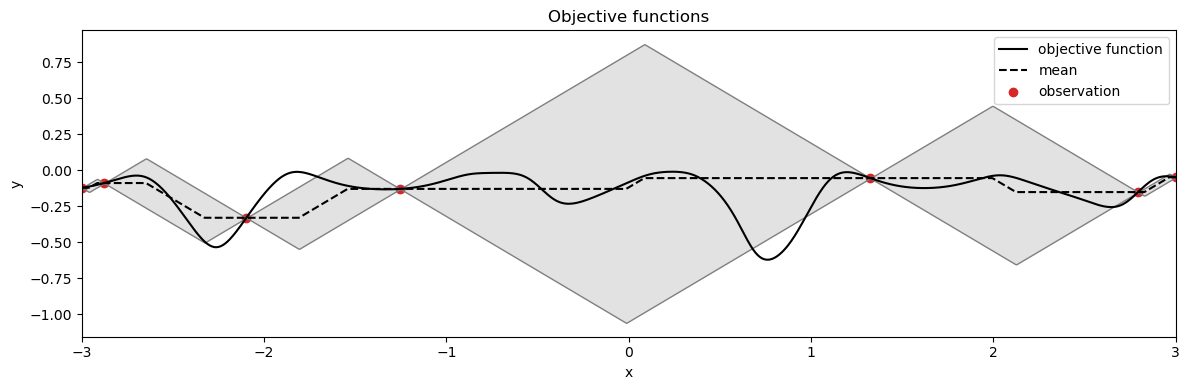

In [15]:
plt.figure(figsize=(12, 4))
ax_func = plt.subplot2grid((1, 1), (0, 0), colspan=1)
ax_func.plot(x_dense, gp_posterior.mean, label="objective function", color='k')
ax_func.plot(x_dense, torch.mean(torch.stack((preds_upper, preds_lower)), dim=0), label="mean", color='k', linestyle='--')
ax_func.scatter(x_obs, y_obs, label="observation", color='tab:red')
ax_func.fill_between(x_dense.flatten(), preds_upper, preds_lower, edgecolor='#7f7f7f', facecolor='#7f7f7f39')
ax_func.set_xlabel("x")
ax_func.set_ylabel("y")
ax_func.set_xlim(bounds)
ax_func.set_title("Objective functions")
ax_func.legend()
plt.tight_layout()

### Exploitation mode

In [16]:
min_idx = torch.argmin(y_obs)
x_obs_min = x_obs[min_idx]
y_obs_min = y_obs[min_idx]

def s(x, y):
    return (y - y_obs_min) / torch.norm(x - x_obs_min)

x_intercept = []
for x, y in zip(x_obs, y_obs):
    intercept = (x_obs_min + 0.5 * (1 - s(x, y) / smgo.gamma) * (x - x_obs_min)).item()
    if not np.isnan(intercept):
        x_intercept.append(intercept)
x_intercept = torch.tensor(x_intercept)
_, y_intercept = smgo.predict(x_intercept.reshape(-1, 1))

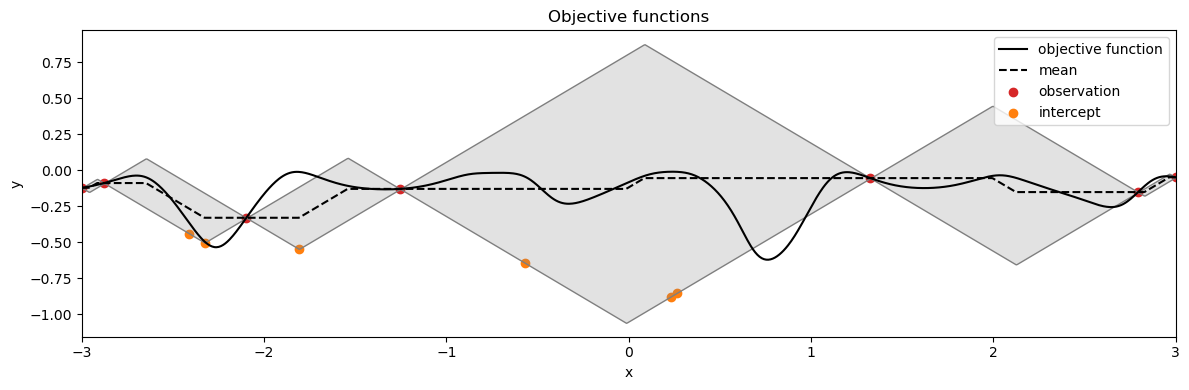

In [17]:
plt.figure(figsize=(12, 4))
ax_func = plt.subplot2grid((1, 1), (0, 0), colspan=1)
ax_func.plot(x_dense, gp_posterior.mean, label="objective function", color='k')
ax_func.plot(x_dense, torch.mean(torch.stack((preds_upper, preds_lower)), dim=0), label="mean", color='k', linestyle='--')
ax_func.scatter(x_obs, y_obs, label="observation", color='tab:red')
ax_func.scatter(x_intercept, y_intercept, label="intercept", color='tab:orange')
ax_func.fill_between(x_dense.flatten(), preds_upper, preds_lower, edgecolor='#7f7f7f', facecolor='#7f7f7f39')
ax_func.set_xlabel("x")
ax_func.set_ylabel("y")
ax_func.set_xlim(bounds)
ax_func.set_title("Objective functions")
ax_func.legend()
plt.tight_layout()

### Optimization loop

Exploitation


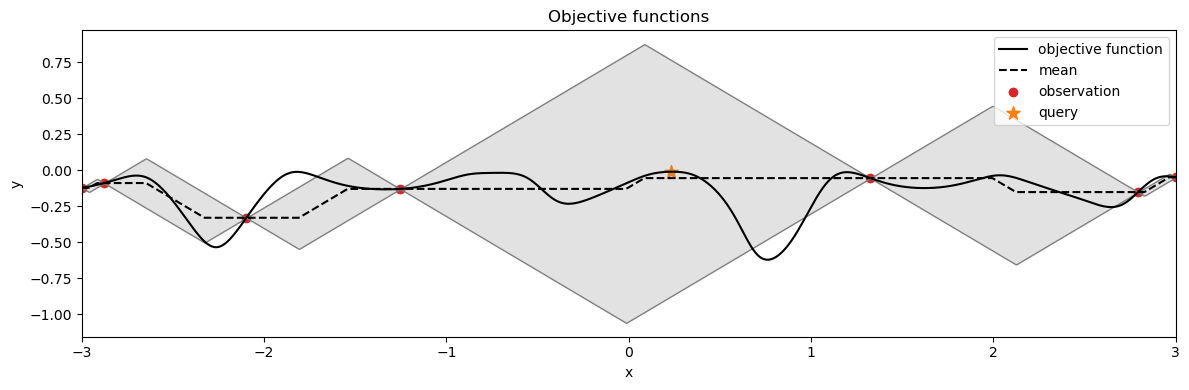

Exploitation


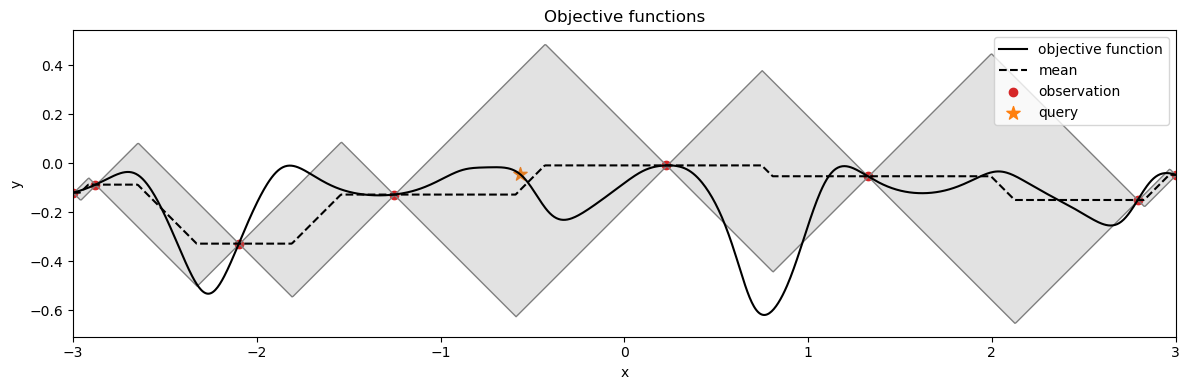

Exploitation


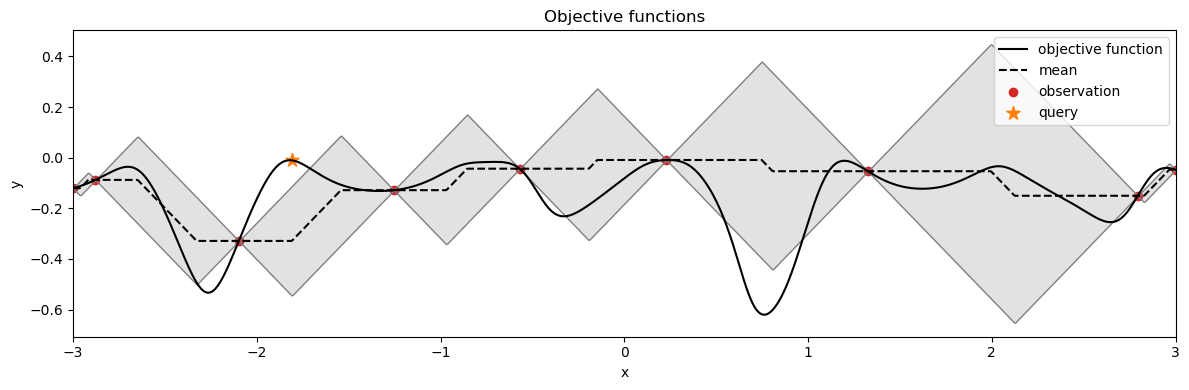

Exploitation


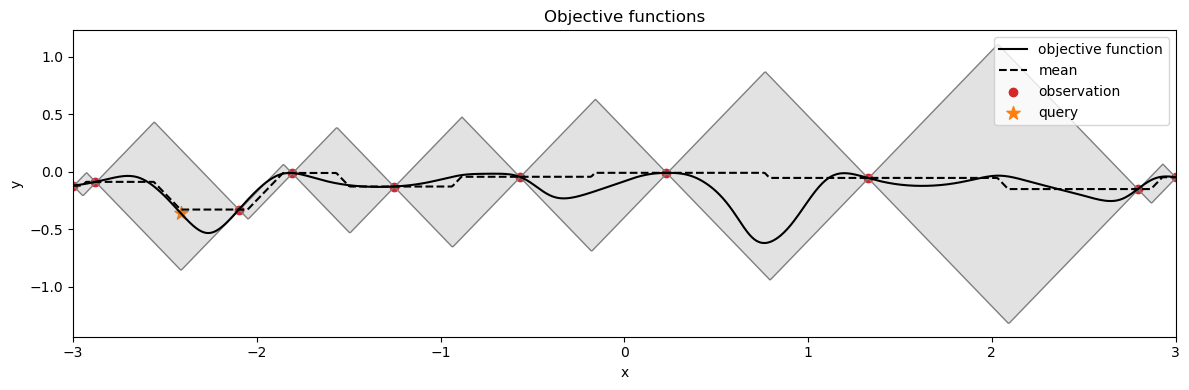

Exploitation


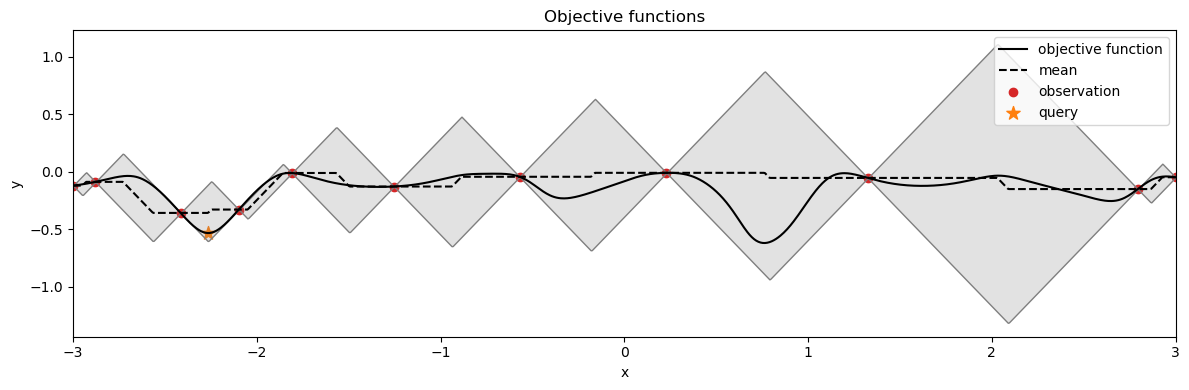

Exploration


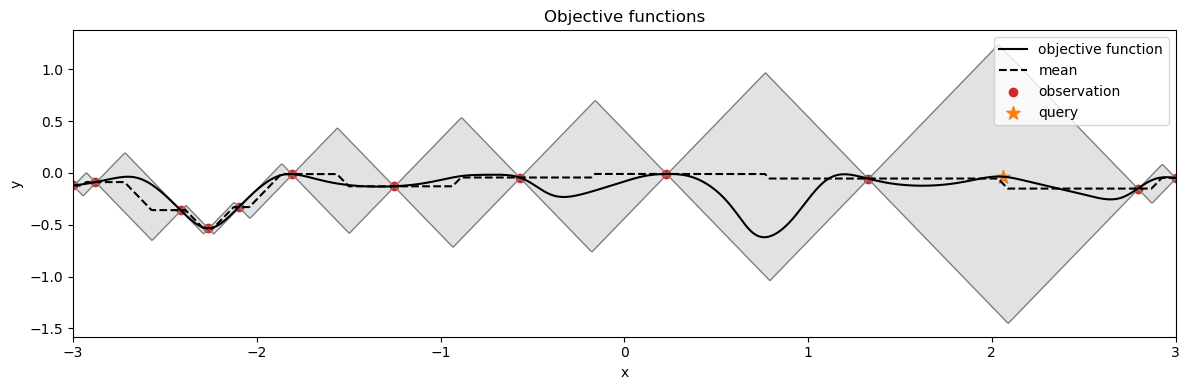

Exploration


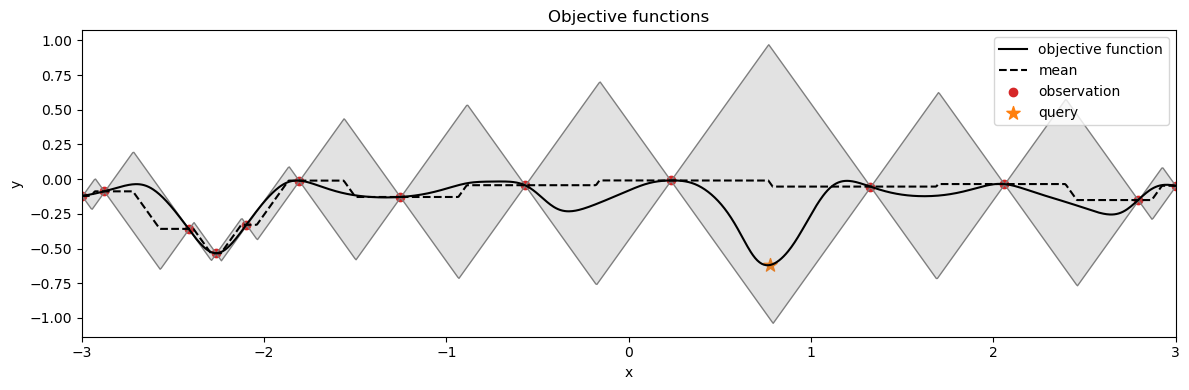

Exploitation


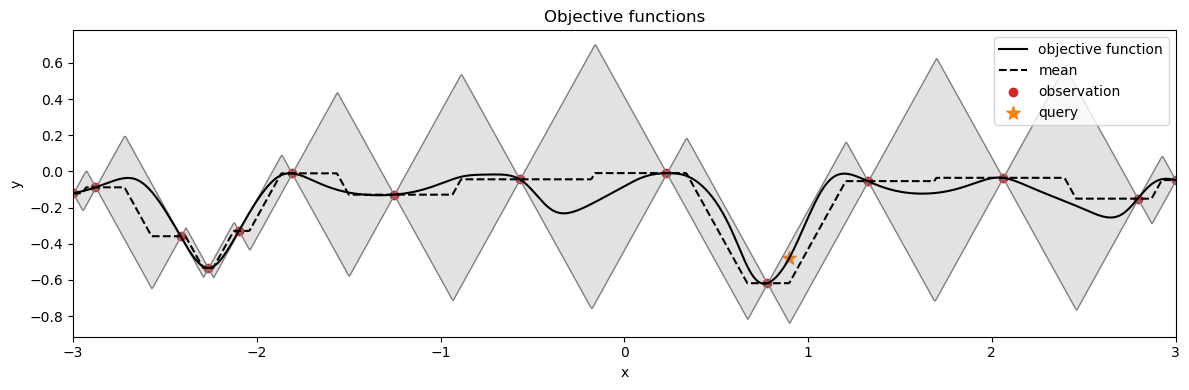

Exploitation


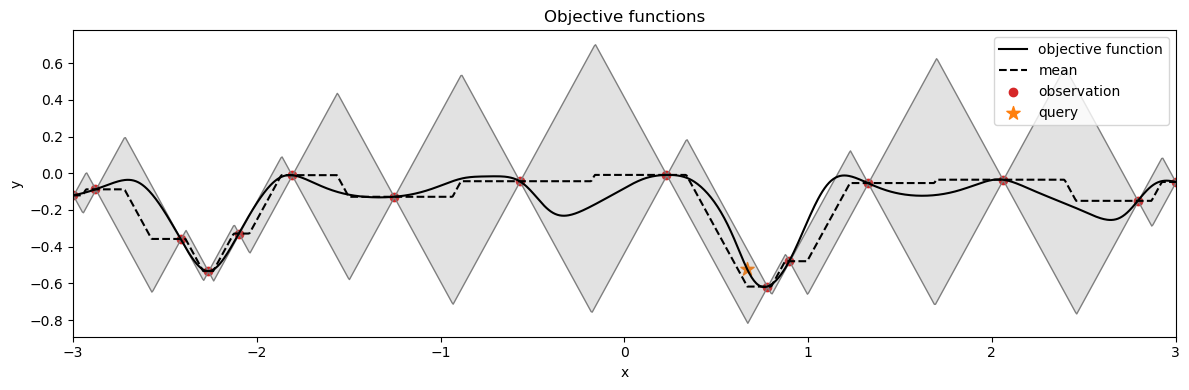

Exploration


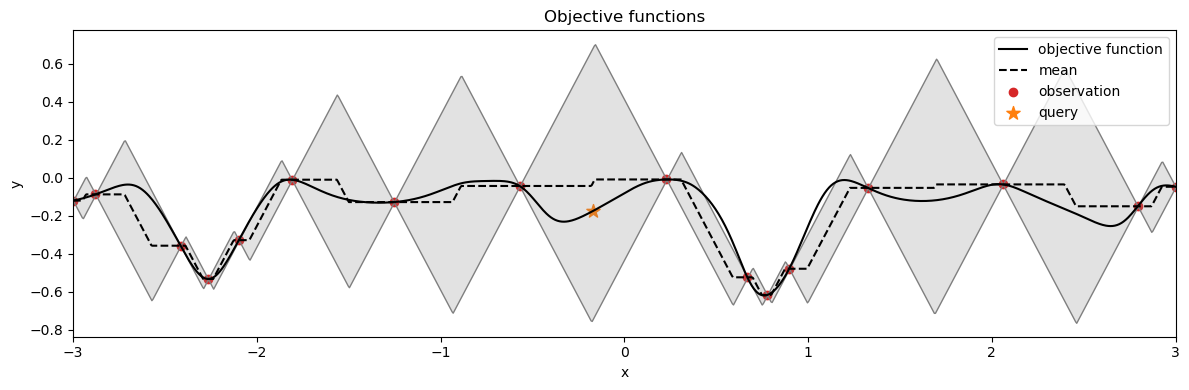

In [18]:
smgo = SMGO(alpha=0.1)
for _ in range(10):
    smgo.fit(x_obs, y_obs)
    new_x = smgo.propose()
    with torch.no_grad():
        new_y = gp(new_x).mean
    preds_upper, preds_lower = smgo.predict(x_dense)

    plt.figure(figsize=(12, 4))
    ax_func = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    ax_func.plot(x_dense, gp_posterior.mean, label="objective function", color='k')
    ax_func.plot(x_dense, torch.mean(torch.stack((preds_upper, preds_lower)), dim=0), label="mean", color='k', linestyle='--')
    ax_func.scatter(x_obs, y_obs, label="observation", color='tab:red')
    ax_func.scatter(new_x, new_y, label="query", color='tab:orange', marker='*',s=100)
    ax_func.fill_between(x_dense.flatten(), preds_upper, preds_lower, edgecolor='#7f7f7f', facecolor='#7f7f7f39')
    ax_func.set_xlabel("x")
    ax_func.set_ylabel("y")
    ax_func.set_xlim(bounds)
    ax_func.set_title("Objective functions")
    ax_func.legend()
    plt.tight_layout()
    plt.show()

    x_obs = torch.cat((x_obs, new_x))
    y_obs = torch.cat((y_obs, new_y))